# Stage 1: Correlation for individual enhancers

In [1]:
import pandas as pd
import numpy as np
import time, re, datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import zscore
import random

from multiprocessing import Pool,cpu_count
num_processors = cpu_count()

print('Starting analysis; %d processors; %s' % (num_processors, datetime.datetime.today()))
t00 =time.time()

# np.random.seed(0)
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
from __init__jupyterlab import *
import snmcseq_utils

Starting analysis; 40 processors; 2020-06-21 15:31:10.025729


In [2]:
today=datetime.datetime.today().strftime('%d-%m-%Y')
use_kmers = False
corr_type = 'Pearson' # corr_type = 'Spearman'
features_use = 'mCG'

output_fig = '/cndd2/fangming/projects/scf_enhancers/results/figures/eran_model_{{}}_{}.pdf'.format(today)
output = '/cndd2/fangming/projects/scf_enhancers/results/eran_model_{{}}_{}'.format(today)

In [3]:
# fn_load_prefix = 'RegressData/Regress_data_6143genes_19cells_'
# fn_load_prefix = 'RegressData/Regress_data_6174genes_20cells_'
fn_load_prefix = 'RegressData/Regress_data_9811genes_24cells_'

# Load datasets
save_vars = ['genes2enhu', 'rnau', 'df_mlevelu', 'df_atacu', 'genes']
# save_vars = ['rnau','genes']
for var in save_vars:
    fn = fn_load_prefix+var+'.pkl'
    cmd = '%s=pd.read_pickle("%s")' % (var, fn)
    exec(cmd)
    print('Loaded %s from %s' % (var, fn))

if use_kmers:
    with np.load(fn_load_prefix+'kmer_countsu.npz', allow_pickle=True) as x:
        kmer_countsu=x['kmer_countsu']
    kmer_countsu = kmer_countsu/kmer_countsu.shape[1]/100
    
    # Testing:
    kmer_countsu = kmer_countsu[:,:2]
    
    print('Kmers shape: ', kmer_countsu.shape)
    Nk=kmer_countsu.shape[1]
    print('Loaded kmers')
else:
    Nk=0
    
# Cell type names
df_cellnames = pd.read_csv(
    '/cndd/Public_Datasets/CEMBA/BICCN_minibrain_data/data_freeze/supp_info/clusters_final/cluster_annotation_scf_round2.tsv',
                       sep='\t', index_col='cluster')

Loaded genes2enhu from RegressData/Regress_data_9811genes_24cells_genes2enhu.pkl
Loaded rnau from RegressData/Regress_data_9811genes_24cells_rnau.pkl
Loaded df_mlevelu from RegressData/Regress_data_9811genes_24cells_df_mlevelu.pkl
Loaded df_atacu from RegressData/Regress_data_9811genes_24cells_df_atacu.pkl
Loaded genes from RegressData/Regress_data_9811genes_24cells_genes.pkl


In [4]:
# ngenes_use = 500000000
# genes = genes.iloc[np.random.permutation(genes.shape[0])[:ngenes_use],:]

In [5]:
genes2enhu = genes2enhu.iloc[[i in genes.index for i in genes2enhu['ensid']],:]
genes2enhu.shape, genes2enhu.index.unique().shape

celltypes = df_mlevelu.columns

In [6]:
if (features_use=='mCG'):
    x = df_mlevelu.loc[genes2enhu['enh_pos'],:].to_numpy()
elif (features_use=='ATAC'):
    x = df_atacu.loc[genes2enhu['enh_pos'],:].to_numpy()
elif (features_use=='mCG_ATAC'):
    x1 = df_mlevelu.loc[genes2enhu['enh_pos'],:].to_numpy()
    x2 = df_atacu.loc[genes2enhu['enh_pos'],:].to_numpy()
    x = f_mcg(x1) * f_atac(x2)
else:
    x = []
    
y = rnau.loc[genes2enhu['ensid'],:].to_numpy()

In [7]:
genes2enhu.head()

,gene_chr,gene_start,gene_end,gene_strand,ensid,gene_name,enh_chr,enh_start,enh_end,tss,enh_ctr,dtss,enh_pos
ensid,,,,,,,,,,,,,
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108010321,108010428,108146146,108010374.5,135771.5,chr3_108010321_108010428
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108012852,108013721,108146146,108013286.5,132859.5,chr3_108012852_108013721
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108017284,108017576,108146146,108017430.0,128716.0,chr3_108017284_108017576
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108018360,108018630,108146146,108018495.0,127651.0,chr3_108018360_108018630
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108019008,108019178,108146146,108019093.0,127053.0,chr3_108019008_108019178


In [8]:
print(
    rnau.shape, # rna by celltype
    df_mlevelu.shape, # enh by cell type
    df_atacu.shape, # enh by cell type
    
    genes.shape, # gene annotation
    genes2enhu.shape, # gene-enh pair 
    
    x.shape, # enh_mcg by cell type (mcg_enh for each enh-gene pair) how ?
    y.shape, # rna by cell type (rna for each enh-gene pair)
    )

(9811, 24) (242461, 24) (242461, 24) (51809, 6) (468604, 13) (468604, 24) (468604, 24)


In [59]:
def my_cc(x,y,ensid,doshuff=False,jshuff=0,corr_type='Pearson',use_abs=True, doshuffgene=False):
    """Calculate corr for each row of x and y
    x, y: enh_mcg/gene_rna (pair) vs celltype
    ensid: matched gene ensid for each row
    
    x, y contains no nan; but constant rows of x and y produces nan with zscoring
    """
    t0=time.time()
#     seed = int(time.time()*1e7 % 100)
#     np.random.seed(seed)
    
    ngenes, ncells = y.shape
    print('Computing correlations for %d gene-enhancer pairs; jshuff=%d; ' % (ngenes, jshuff))
    if doshuff:
        y = y[:,np.random.permutation(ncells)] # permute cells
    if doshuffgene:
        y = y[np.random.permutation(ngenes),:] # permute genes (pairs)

    if (corr_type=='Spearman'):
        y = np.argsort(y,axis=1)
        x = np.argsort(x,axis=1)
    xz = zscore(x, axis=1, nan_policy='propagate', ddof=0)
    yz = zscore(y, axis=1, nan_policy='propagate', ddof=0)
    xy_cc = np.nan_to_num(np.nanmean(xz*yz, axis=1)) # turn np.nan into zero

    xy_cc_df = pd.DataFrame(data=xy_cc, columns=['cc'])
    xy_cc_df['enh_num'] = np.arange(ngenes)
    xy_cc_df['ensid'] = ensid.values
    xy_cc_df['cc_abs'] = np.abs(xy_cc_df['cc'])
    if use_abs: # max abs_corr for each gene
        xy_cc_df = xy_cc_df.sort_values(['ensid','cc_abs'],
                                        ascending=[True,False]).drop_duplicates(['ensid'])
    else: # max corr for each gene 
        xy_cc_df = xy_cc_df.sort_values(['ensid','cc'],
                                        ascending=[True,False]).drop_duplicates(['ensid'])
    best_cc    = xy_cc_df['cc'] # corr (not abs)
    best_enh   = xy_cc_df['enh_num'] # enh
    best_ensid = xy_cc_df['ensid'] # gene
    print('t=%3.3f' % (time.time()-t0))
    
    return best_cc,best_enh,best_ensid,xy_cc

In [60]:
import warnings
warnings.filterwarnings('ignore') 

best_cc, best_enh, best_ensid, all_cc = my_cc(x,y,genes2enhu['ensid'],False,0,corr_type,True,False)
print(best_cc.shape, best_enh.shape, best_ensid.shape, all_cc.shape)

Computing correlations for 468604 gene-enhancer pairs; jshuff=0; 
t=0.897
(9811,) (9811,) (9811,) (468604,)


In [66]:
num_processors = 40
nshuff = np.min((num_processors*16,128))
np.random.seed(0)
num_processors = 1

t0=time.time()
with Pool(processes = num_processors) as p:
    best_cc_shuff_list = p.starmap(my_cc, 
                                   [(x,y,genes2enhu['ensid'],True,jshuff,corr_type,True,False) for jshuff in range(nshuff)])
print('All done, t=%3.3f s' % (time.time()-t0))

Computing correlations for 468604 gene-enhancer pairs; jshuff=0; 
t=0.822
Computing correlations for 468604 gene-enhancer pairs; jshuff=1; 
t=0.882
Computing correlations for 468604 gene-enhancer pairs; jshuff=2; 
t=0.827
Computing correlations for 468604 gene-enhancer pairs; jshuff=3; 
t=0.829
Computing correlations for 468604 gene-enhancer pairs; jshuff=4; 
t=0.821
Computing correlations for 468604 gene-enhancer pairs; jshuff=5; 
t=0.774
Computing correlations for 468604 gene-enhancer pairs; jshuff=6; 
t=0.794
Computing correlations for 468604 gene-enhancer pairs; jshuff=7; 
t=0.873
Computing correlations for 468604 gene-enhancer pairs; jshuff=8; 
t=0.795
Computing correlations for 468604 gene-enhancer pairs; jshuff=9; 
t=0.906
Computing correlations for 468604 gene-enhancer pairs; jshuff=10; 
t=0.843
Computing correlations for 468604 gene-enhancer pairs; jshuff=11; 
t=0.800
Computing correlations for 468604 gene-enhancer pairs; jshuff=12; 
t=0.855
Computing correlations for 468604 g

In [67]:
alpha = 0.01;
best_cc_shuff = np.hstack([b[0].values[:,np.newaxis] for b in best_cc_shuff_list]) # gene (best corr) by num_shuff
best_cc_shuff_max = np.percentile(np.abs(best_cc_shuff), 100*(1-alpha), axis=1) # get 99% (robust max) across shuffles 
best_cc_shuff_mean = np.abs(best_cc_shuff).mean(axis=1) # get mean across shuffles for each gene
sig = np.abs(best_cc).squeeze()>best_cc_shuff_max # corr greater than 99% of the shuffled

# len(sig) tests (num_genes) - num_FP (under H0) = alpha*len(sig) [expected num]
# fdr = expected/observed
# fdr = P(H0|r>r0) = P(r>r0|H0)P(H0)/P(r>r0) <= P(r>r0|H0)/P(r>r0) = expected under null/observed

fdr = (alpha*len(sig))/np.sum(sig) # fdr - alpha
print(np.sum(sig), len(sig), alpha, fdr)

5227 9811 0.01 0.0187698488617


Saved /cndd2/fangming/projects/scf_enhancers/results/eran_model_genes_corr_mCG_Pearson_21-06-2020


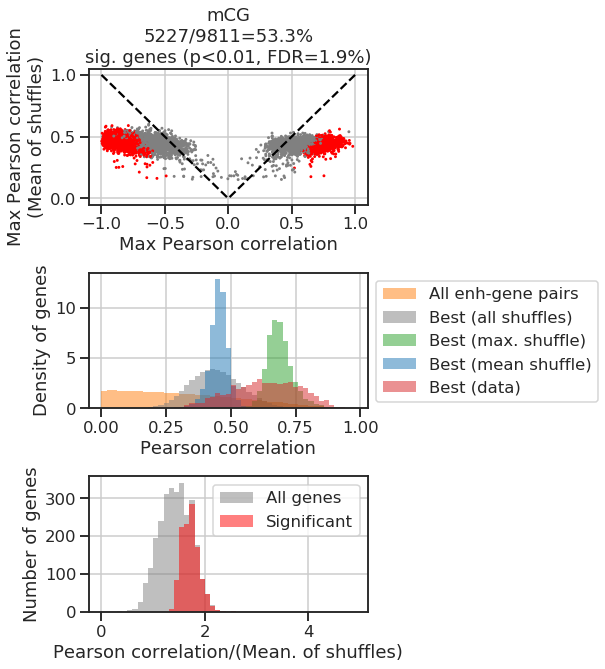

In [68]:
ngenes = best_cc.shape[0]

fig, axs = plt.subplots(3,1,figsize=(5,10))
ax = axs[0]
ax.scatter(best_cc, best_cc_shuff_mean,
         s=2,c=sig,
         cmap=ListedColormap(["gray",'red']), 
         rasterized=True,
         )
ax.plot([-1,0,1],[1,0,1],'k--')
ax.set_xlabel('Max %s correlation' % corr_type)
ax.set_ylabel('Max %s correlation\n(Mean of shuffles)' % corr_type)
ax.set_title('%s\n%d/%d=%3.1f%%\nsig. genes (p<%3.2g, FDR=%3.1f%%)' % (features_use, 
                                                                 sig.sum(),ngenes,
                                                                 100*sig.sum()/ngenes,
                                                                 alpha, fdr*100), )

ax = axs[1]
bins = bins=np.arange(0,1,0.02)
hist_config = {
    'histtype': 'bar', 
    'edgecolor': 'none',
    'alpha': 0.5, 
    'density': True, 
}
ax.hist(np.abs(all_cc), bins=bins,
        color='C1',
        label='All enh-gene pairs',
        **hist_config,
       )
ax.hist(best_cc_shuff.reshape(-1,1), bins=bins,
        color='gray',
        label='Best (all shuffles)',
        **hist_config,
        )
ax.hist(best_cc_shuff_max, bins=bins,
        color='C2',
        label='Best (max. shuffle)',
        **hist_config,
       )
ax.hist(best_cc_shuff_mean, bins=bins,
        color='C0',
        label='Best (mean shuffle)',
        **hist_config,
       )
ax.hist(best_cc.squeeze(), bins=bins,
        color='C3',
        label='Best (data)',
        **hist_config,
       )
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel(corr_type+' correlation')
ax.set_ylabel('Density of genes')

ax = axs[2]
bins = np.arange(0,5,0.1)
hist_config = {
    'histtype': 'bar', 
    'edgecolor': 'none',
    'alpha': 0.5, 
    'density': False, 
}
ax.hist(best_cc.squeeze()/best_cc_shuff_mean.squeeze(), bins=bins,
        color='gray', label='All genes', 
        **hist_config,
       )
ax.hist((best_cc.squeeze()/best_cc_shuff_mean.squeeze())[sig], bins=bins,
        color='red', label='Significant', 
        **hist_config,
       )
ax.set_xlabel(corr_type+' correlation/(Mean. of shuffles)')
ax.set_ylabel('Number of genes')
ax.legend(bbox_to_anchor=(1,1))

fig.subplots_adjust(hspace=0.5)
fn_plot = output.format("genes_corr_"+features_use+'_'+corr_type)
snmcseq_utils.savefig(fig, fn_plot)
print('Saved %s' % fn_plot)

In [69]:
# np.savez(
#          output.format('GenesCorr_%s_%s.npz' % (features_use, today)), 
#          best_cc=best_cc,best_enh=best_enh,best_ensid=best_ensid,
#          sig=sig, best_cc_shuff=best_cc_shuff)
# print('Saved data; t=%3.3f; %s' % (time.time()-t00, datetime.datetime.today()))

Text(0,0.5,'corr for a gene-enh pair')

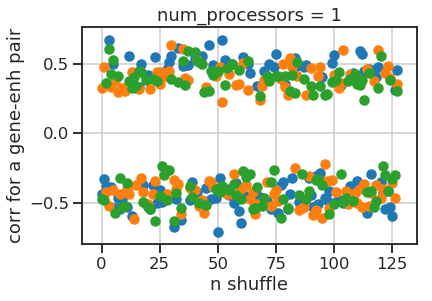

In [71]:
# check randomness

plt.scatter(np.arange(best_cc_shuff.shape[1]), best_cc_shuff[0])
plt.scatter(np.arange(best_cc_shuff.shape[1]), best_cc_shuff[1])
plt.scatter(np.arange(best_cc_shuff.shape[1]), best_cc_shuff[2])
plt.title("num_processors = {}".format(num_processors))
plt.xlabel('n shuffle')
plt.ylabel('corr for a gene-enh pair')

In [21]:
genes2enhu['cc'] = all_cc
genes2enhu.head()

,gene_chr,gene_start,gene_end,gene_strand,ensid,gene_name,enh_chr,enh_start,enh_end,tss,enh_ctr,dtss,enh_pos,cc
ensid,,,,,,,,,,,,,,
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108010321,108010428,108146146,108010374.5,135771.5,chr3_108010321_108010428,-0.249313
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108012852,108013721,108146146,108013286.5,132859.5,chr3_108012852_108013721,-0.010517
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108017284,108017576,108146146,108017430.0,128716.0,chr3_108017284_108017576,0.011419
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108018360,108018630,108146146,108018495.0,127651.0,chr3_108018360_108018630,-0.207659
ENSMUSG00000000001,chr3,108107280,108146146,-,ENSMUSG00000000001,Gnai3,chr3,108019008,108019178,108146146,108019093.0,127053.0,chr3_108019008_108019178,-0.333050


In [125]:
best_ensid_inv = pd.Series(best_ensid.index.values, index=best_ensid)
i = best_ensid_inv.loc[genes2enhu.index].values
genes2enhu['best_cc'] = genes2enhu.iloc[i,:]['cc']

i = pd.Series(np.arange(best_ensid.shape[0]), index=best_ensid)
genes2enhu['best_cc_shuff_max'] = best_cc_shuff_max[i.loc[genes2enhu.index]]
isig = sig[best_ensid_inv.loc[genes2enhu.index]].values
genes2enhu['sig'] = (genes2enhu['cc'].abs() >= genes2enhu['best_cc_shuff_max'].abs()) 
genes2enhu['nonsig'] = (genes2enhu['cc'].abs() < genes2enhu['best_cc_shuff_max'].abs())

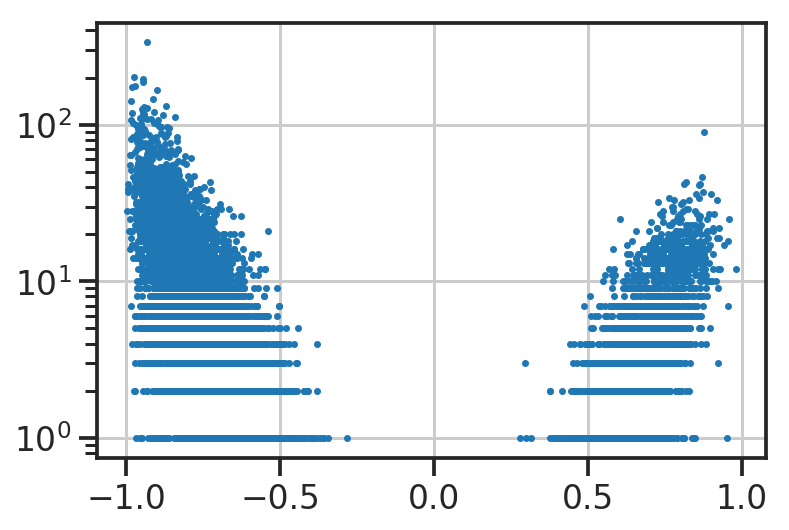

In [126]:
# How many enhancers are 
# best_cc_shuff_max
nsig = genes2enhu.groupby(level=0).sum()[['sig','nonsig']]
nsig['best_cc'] = best_cc.values
plt.semilogy(nsig['best_cc'], nsig['sig'],  '.',
            markersize=5);

In [127]:
nsig['gene_name'] = genes2enhu.loc[nsig.index,:]['gene_name'].drop_duplicates()
nsig.sort_values('sig').iloc[-10:,:]

,sig,nonsig,best_cc,gene_name
ensid,,,,
ENSMUSG00000039809,132.0,159.0,-0.870722,Gabbr2
ENSMUSG00000033278,141.0,72.0,-0.983454,Ptprm
ENSMUSG00000005583,146.0,28.0,-0.912726,Mef2c
ENSMUSG00000063142,167.0,133.0,-0.901539,Kcnma1
ENSMUSG00000052551,173.0,51.0,-0.982806,Adarb2
ENSMUSG00000032503,176.0,14.0,-0.971614,Arpp21
ENSMUSG00000022332,186.0,11.0,-0.947037,Khdrbs3
ENSMUSG00000061751,197.0,138.0,-0.946268,Kalrn
ENSMUSG00000053477,203.0,96.0,-0.973257,Tcf4


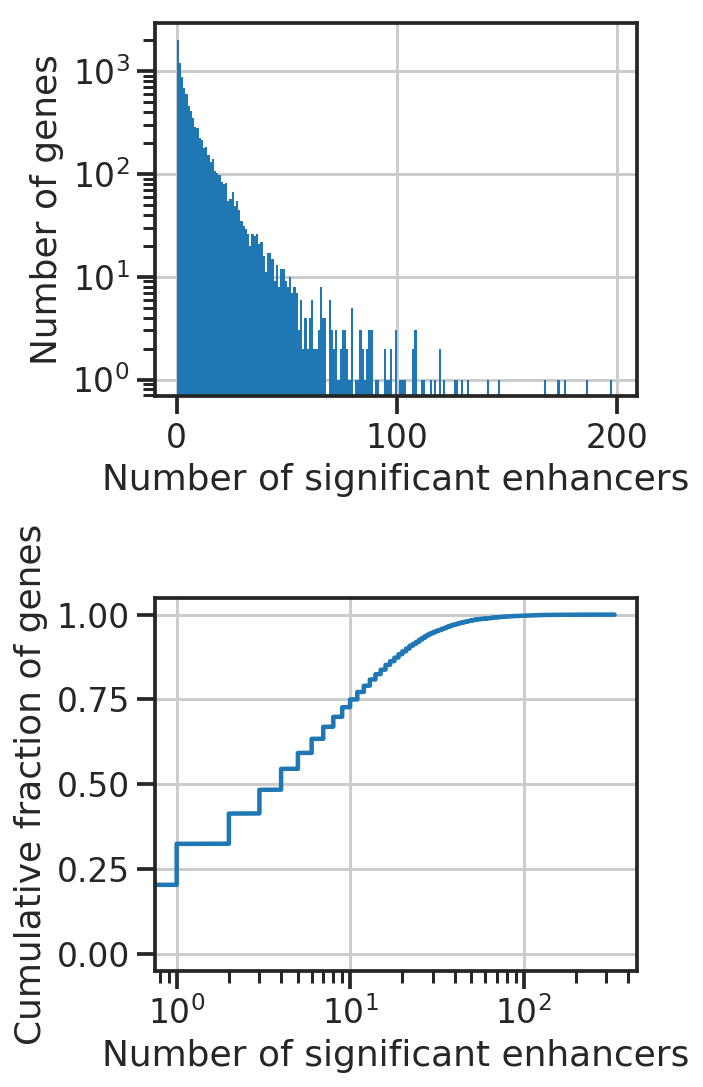

In [161]:
def my_cdfplot(ax, x, label=''):
    ax.semilogx(np.sort(np.abs(x)), np.linspace(0,1,len(x)), 
                label='%s (%d)\nd=%3.1f±%3.1f kb' %
                 (label, len(x), x.mean()/1000, x.std()/1000/np.sqrt(len(x))))
    return

fig, axs = plt.subplots(2, 1, figsize=(5,8))

ax = axs[0]
hist_config = {
    'histtype': 'bar', 
    'edgecolor': 'none',
    'alpha': 1, 
    'density': False, 
}
ax.hist(nsig['sig'].values, bins=np.arange(200),
         **hist_config
        )
ax.set_xlabel('Number of significant enhancers')
ax.set_ylabel('Number of genes')
ax.set_yscale('log')

ax = axs[1]
my_cdfplot(ax, nsig['sig'].values,)
ax.set_xlabel('Number of significant enhancers')
ax.set_ylabel('Cumulative fraction of genes')
fig.tight_layout()

snmcseq_utils.savefig(fig, 
                      output_fig.format('GenesCorr_NumSigEnh_%s_%s_%s.pdf' % (features_use, today, corr_type))
                     )


## Comments
- Worth doing this analysis by gene (redo)

- Negative and positive corr not distinguished
- Shuffling control not shuffled by genes

# Stage 2: Regression modeling across all genes

In [136]:
# Are there any duplicate enhancers?
nenh_sig = genes2enhu.iloc[(best_enh[sig].values),:]['enh_pos'].shape[0]
nenh_sig_unique = genes2enhu.iloc[(best_enh[sig].values),:]['enh_pos'].unique().shape[0]
nenh_sig_genes_unique = genes2enhu.iloc[(best_enh[sig].values),:]['ensid'].unique().shape[0]

In [137]:
mc_u   = df_mlevelu.loc[genes2enhu['enh_pos'],:].to_numpy()[best_enh[sig],:]
atac_u = df_atacu.loc[genes2enhu['enh_pos'],:].to_numpy()[best_enh[sig],:]
genes2enhu_u = genes2enhu.iloc[best_enh[sig],:].copy()
genes2enhu_u = genes2enhu_u.drop('ensid',axis=1).reset_index()

rna_u = rnau.loc[genes2enhu['ensid'],:].to_numpy()
rna_u = rna_u[best_enh[sig],:].copy()

In [138]:
genes2enhu.iloc[(best_enh[sig].values),:]['enh_pos'].shape

(7818,)

In [139]:
cc_mc_rna = np.array([np.corrcoef(x1,y1)[0,1] for (x1,y1) in zip(mc_u,rna_u)])
cc_atac_rna = np.array([np.corrcoef(x1,y1)[0,1] for (x1,y1) in zip(atac_u,rna_u)])

In [140]:
genes2enhu_u.loc[:,'cc_mc_rna'] = cc_mc_rna
genes2enhu_u.loc[:,'cc_atac_rna'] = cc_atac_rna
genes2enhu_u.sort_values('cc_mc_rna')
# genes2enhu_u['cc_atac_rna'] = cc_atac_rna

,ensid,gene_chr,gene_start,gene_end,gene_strand,gene_name,enh_chr,enh_start,enh_end,tss,enh_ctr,dtss,enh_pos,cc,best_cc,best_cc_shuff_max,sig,nonsig,cc_mc_rna,cc_atac_rna
2603,ENSMUSG00000026890,chr2,36081953,36105408,-,Lhx6,chr2,36085354,36086833,36105408,36086093.5,19314.5,chr2_36085354_36086833,-0.996553,-0.996553,0.595347,True,False,-0.996553,0.411359
7583,ENSMUSG00000096972,chr2,169633646,169888503,-,Gm26883,chr2,169589992,169590269,169888503,169590130.5,298372.5,chr2_169589992_169590269,-0.994687,-0.994687,0.790733,True,False,-0.994687,0.487295
6006,ENSMUSG00000047907,chr2,169633013,170071816,+,Tshz2,chr2,169589992,169590269,169633013,169590130.5,-42882.5,chr2_169589992_169590269,-0.994095,-0.994095,0.772037,True,False,-0.994095,0.485256
5083,ENSMUSG00000039384,chr1,184013302,184075636,+,Dusp10,chr1,184040161,184040753,184013302,184040457.0,27155.0,chr1_184040161_184040753,-0.994009,-0.994009,0.480863,True,False,-0.994009,0.624849
5696,ENSMUSG00000043668,chr8,90247040,90348343,-,Tox3,chr8,90278167,90279549,90348343,90278858.0,69485.0,chr8_90278167_90279549,-0.990720,-0.990720,0.561506,True,False,-0.990720,0.481221
2060,ENSMUSG00000024642,chr19,14448072,14598051,-,Tle4,chr19,14577068,14577739,14598051,14577403.5,20647.5,chr19_14577068_14577739,-0.988876,-0.988876,0.526231,True,False,-0.988876,0.165076
6268,ENSMUSG00000051910,chr7,115470872,116038796,-,Sox6,chr7,116027060,116027400,116038796,116027230.0,11566.0,chr7_116027060_116027400,-0.988605,-0.988605,0.885456,True,False,-0.988605,0.588164
556,ENSMUSG00000010175,chr1,190118035,190170714,-,Prox1,chr1,190144959,190146326,190170714,190145642.5,25071.5,chr1_190144959_190146326,-0.988562,-0.988562,0.682027,True,False,-0.988562,0.587940
384,ENSMUSG00000005672,chr5,75574916,75656722,+,Kit,chr5,75607272,75608570,75574916,75607921.0,33005.0,chr5_75607272_75608570,-0.987283,-0.987283,0.404021,True,False,-0.987283,0.449864
3601,ENSMUSG00000031216,chrX,99003248,99074728,+,Stard8,chrX,99047452,99047971,99003248,99047711.5,44463.5,chrX_99047452_99047971,-0.986769,-0.986769,0.489406,True,False,-0.986769,0.415355


We found 7818 significant enhancer-gene links, covering 7449 unique enhancers and 7818 unique genes
4565 of these have the expected correlation (negative for mCG, positive for ATAC)
1700 of these have the opposite correlation (positive for mCG, negative for ATAC)


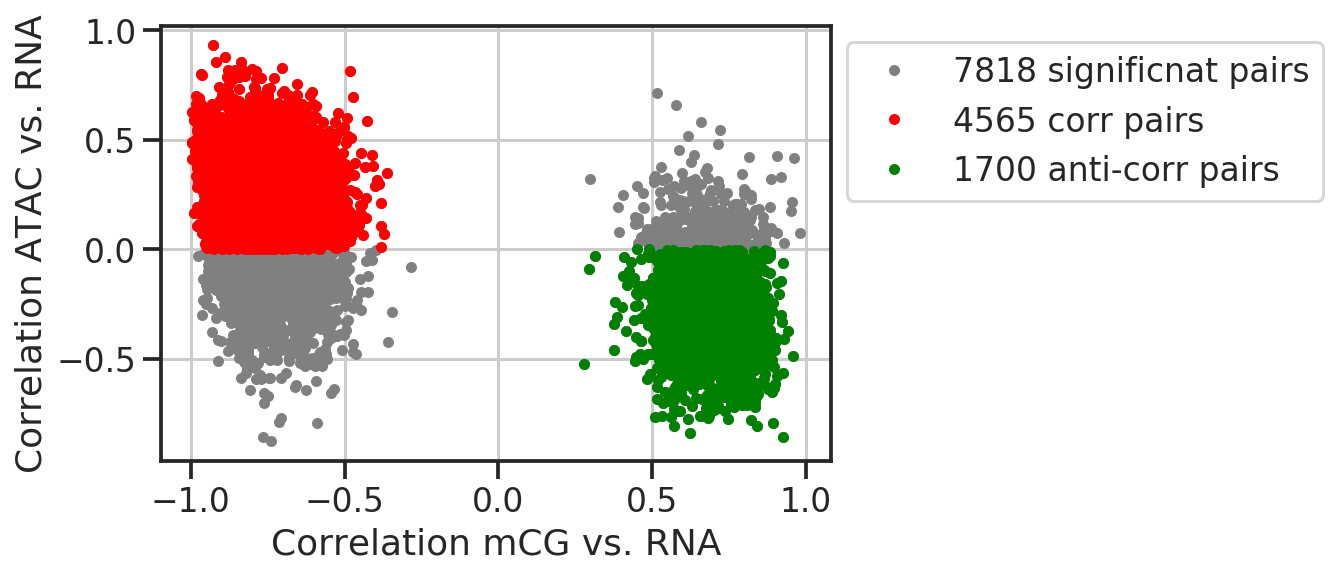

In [147]:
fig, ax = plt.subplots()
sig_pos = (genes2enhu_u['cc_mc_rna']<0) & (genes2enhu_u['cc_atac_rna']>0)
sig_neg = (genes2enhu_u['cc_mc_rna']>0) & (genes2enhu_u['cc_atac_rna']<-0)

ax.plot(cc_mc_rna, cc_atac_rna, '.', color='gray', label='%d significnat pairs' % np.sum(sig))
ax.plot(cc_mc_rna[sig_pos], cc_atac_rna[sig_pos], 'r.', label='%d corr pairs' % np.sum(sig_pos))
ax.plot(cc_mc_rna[sig_neg], cc_atac_rna[sig_neg], 'g.', label='%d anti-corr pairs' % np.sum(sig_neg))
ax.set_xlabel('Correlation mCG vs. RNA')
ax.set_ylabel('Correlation ATAC vs. RNA')
ax.legend(bbox_to_anchor=(1,1))

print('We found %d significant enhancer-gene links, covering %d unique enhancers and %d unique genes' %
     (nenh_sig, nenh_sig_unique, nenh_sig_genes_unique))
print('%d of these have the expected correlation (negative for mCG, positive for ATAC)' %
     (np.sum(sig_pos)))
print('%d of these have the opposite correlation (positive for mCG, negative for ATAC)' %
     (np.sum(sig_neg)))
snmcseq_utils.savefig(fig, output_fig.format(
            'EnhancerRegression_SigEnhancers_scatter_mCG_ATAC_corr_%dGenes_%dCelltypes_%s' % 
            (genes2enhu.ensid.unique().shape[0], len(celltypes), today)
            ))

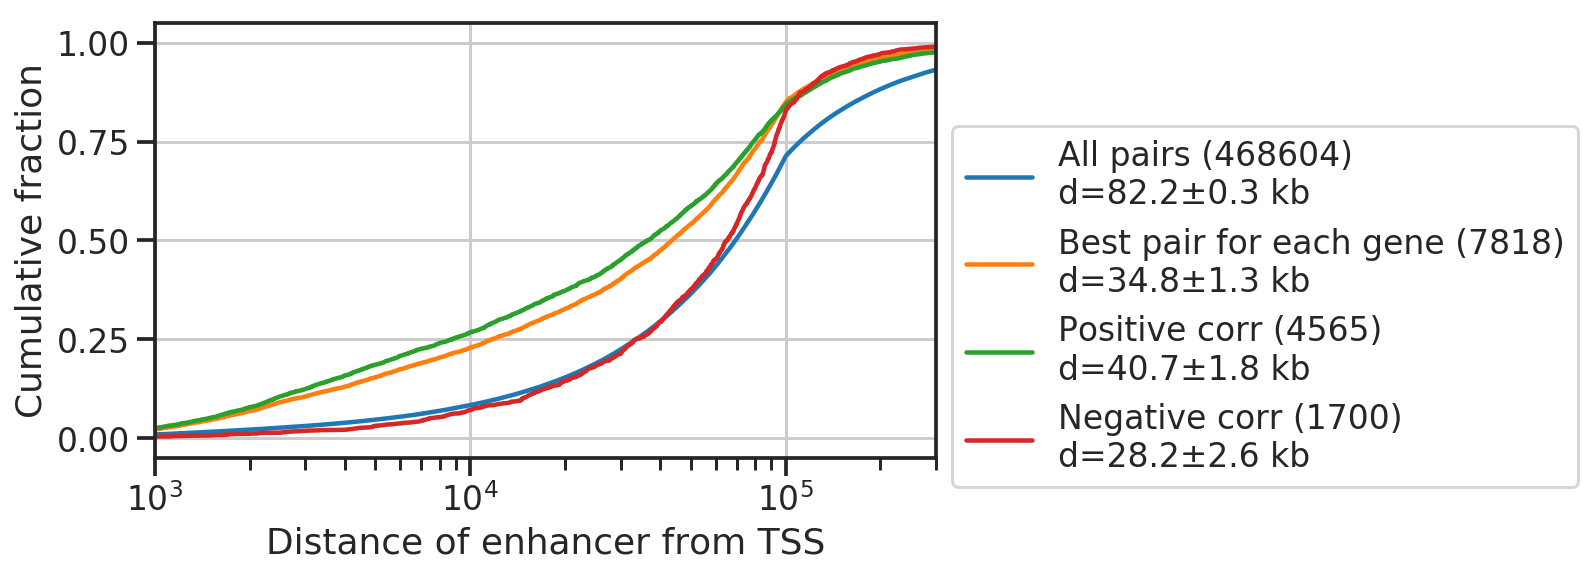

In [162]:
fig, ax = plt.subplots(figsize=(7,4))
my_cdfplot(ax, genes2enhu['dtss'], label='All pairs')
my_cdfplot(ax, genes2enhu_u['dtss'], label='Best pair for each gene')
my_cdfplot(ax, genes2enhu_u['dtss'][sig_pos], label='Positive corr')
my_cdfplot(ax, genes2enhu_u['dtss'][sig_neg], label='Negative corr')

ax.legend(bbox_to_anchor=(1, 0.8))
ax.set_xlim([1e3,3e5])
ax.set_xlabel('Distance of enhancer from TSS')
ax.set_ylabel('Cumulative fraction')
ax.set_yticks(ticks=[0,.25,.5,.75,1]);
snmcseq_utils.savefig(fig, output_fig.format(
            'EnhancerRegression_SigEnhancers_dTSS_cdf_%dGenes_%dCelltypes_%s' % 
           (genes2enhu.ensid.unique().shape[0], len(celltypes), today)
            ))

In [163]:
# Ordinary linear regression with CV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, make_scorer
from sklearn.preprocessing import PolynomialFeatures

mdl = LinearRegression(fit_intercept=True, normalize=True)
X = np.concatenate((mc_u,atac_u),axis=1).copy()
y = np.log10(rna_u+1).copy()

X = zscore(X, axis=0)
y = zscore(y, axis=0)
y = y - np.mean(y,axis=1,keepdims=True)

# X = X[sig_pos,:]
# y = y[sig_pos,:]

ngenes,ncells = y.shape
print('%d genes, %d celltypes' % (ngenes,ncells))

intxn_order = 4

my_r2 = make_scorer(r2_score)
res_cv = {}
cv = 5
for i,yi in enumerate(y.T):
    # Regression using only mCG and ATAC from the same cell type
    Xu = X[:,[i,i+ncells]]
    Xu = np.concatenate((X[:,[i,i+ncells]],
#                      np.mean(X[:,:ncells],axis=1,keepdims=True),
#                      np.mean(X[:,ncells:],axis=1,keepdims=True),
                    ),axis=1)
#     Xu = PolynomialFeatures(degree=3, include_bias=False).fit_transform(Xu)

    res_cvi = cross_validate(mdl,Xu,yi,cv=cv,
                            scoring=my_r2,
                            return_train_score=True,
                            verbose=0)
    if i==0:
        print('Simple model: %d parameters' % Xu.shape[1])
        dof_simple=Xu.shape[1]
    for m in res_cvi:
        if (m in res_cv):
            res_cv[m] = np.vstack((res_cv[m], res_cvi[m]))
        else:
            res_cv[m]=res_cvi[m]
            
    # Regression using mCG and ATAC from the same cell type, as well as the mean across all cell types

#     res_cvi = cross_validate(mdl,X,yi,cv=cv,
#                             scoring=my_r2,
#                             return_train_score=True,
#                             verbose=0)
    Xu = np.concatenate((X[:,[i,i+ncells]],
                         np.mean(X[:,:ncells],axis=1,keepdims=True),
                         np.mean(X[:,ncells:],axis=1,keepdims=True),
                        ),axis=1)
    Xu = PolynomialFeatures(degree=intxn_order, include_bias=False).fit_transform(Xu)

    res_cvi = cross_validate(mdl, Xu, yi,
                            cv=cv,
                            scoring=my_r2,
                            return_train_score=True,
                            verbose=0)
    if i==0:
        print('Complex model: %d parameters' % Xu.shape[1])
        dof_complex=Xu.shape[1]

    for m1 in res_cvi:
        m = m1+'_all'
        if (m in res_cv):
            res_cv[m] = np.vstack((res_cv[m], res_cvi[m1]))
        else:
            res_cv[m]=res_cvi[m1]


7818 genes, 24 celltypes
Simple model: 2 parameters
Complex model: 69 parameters


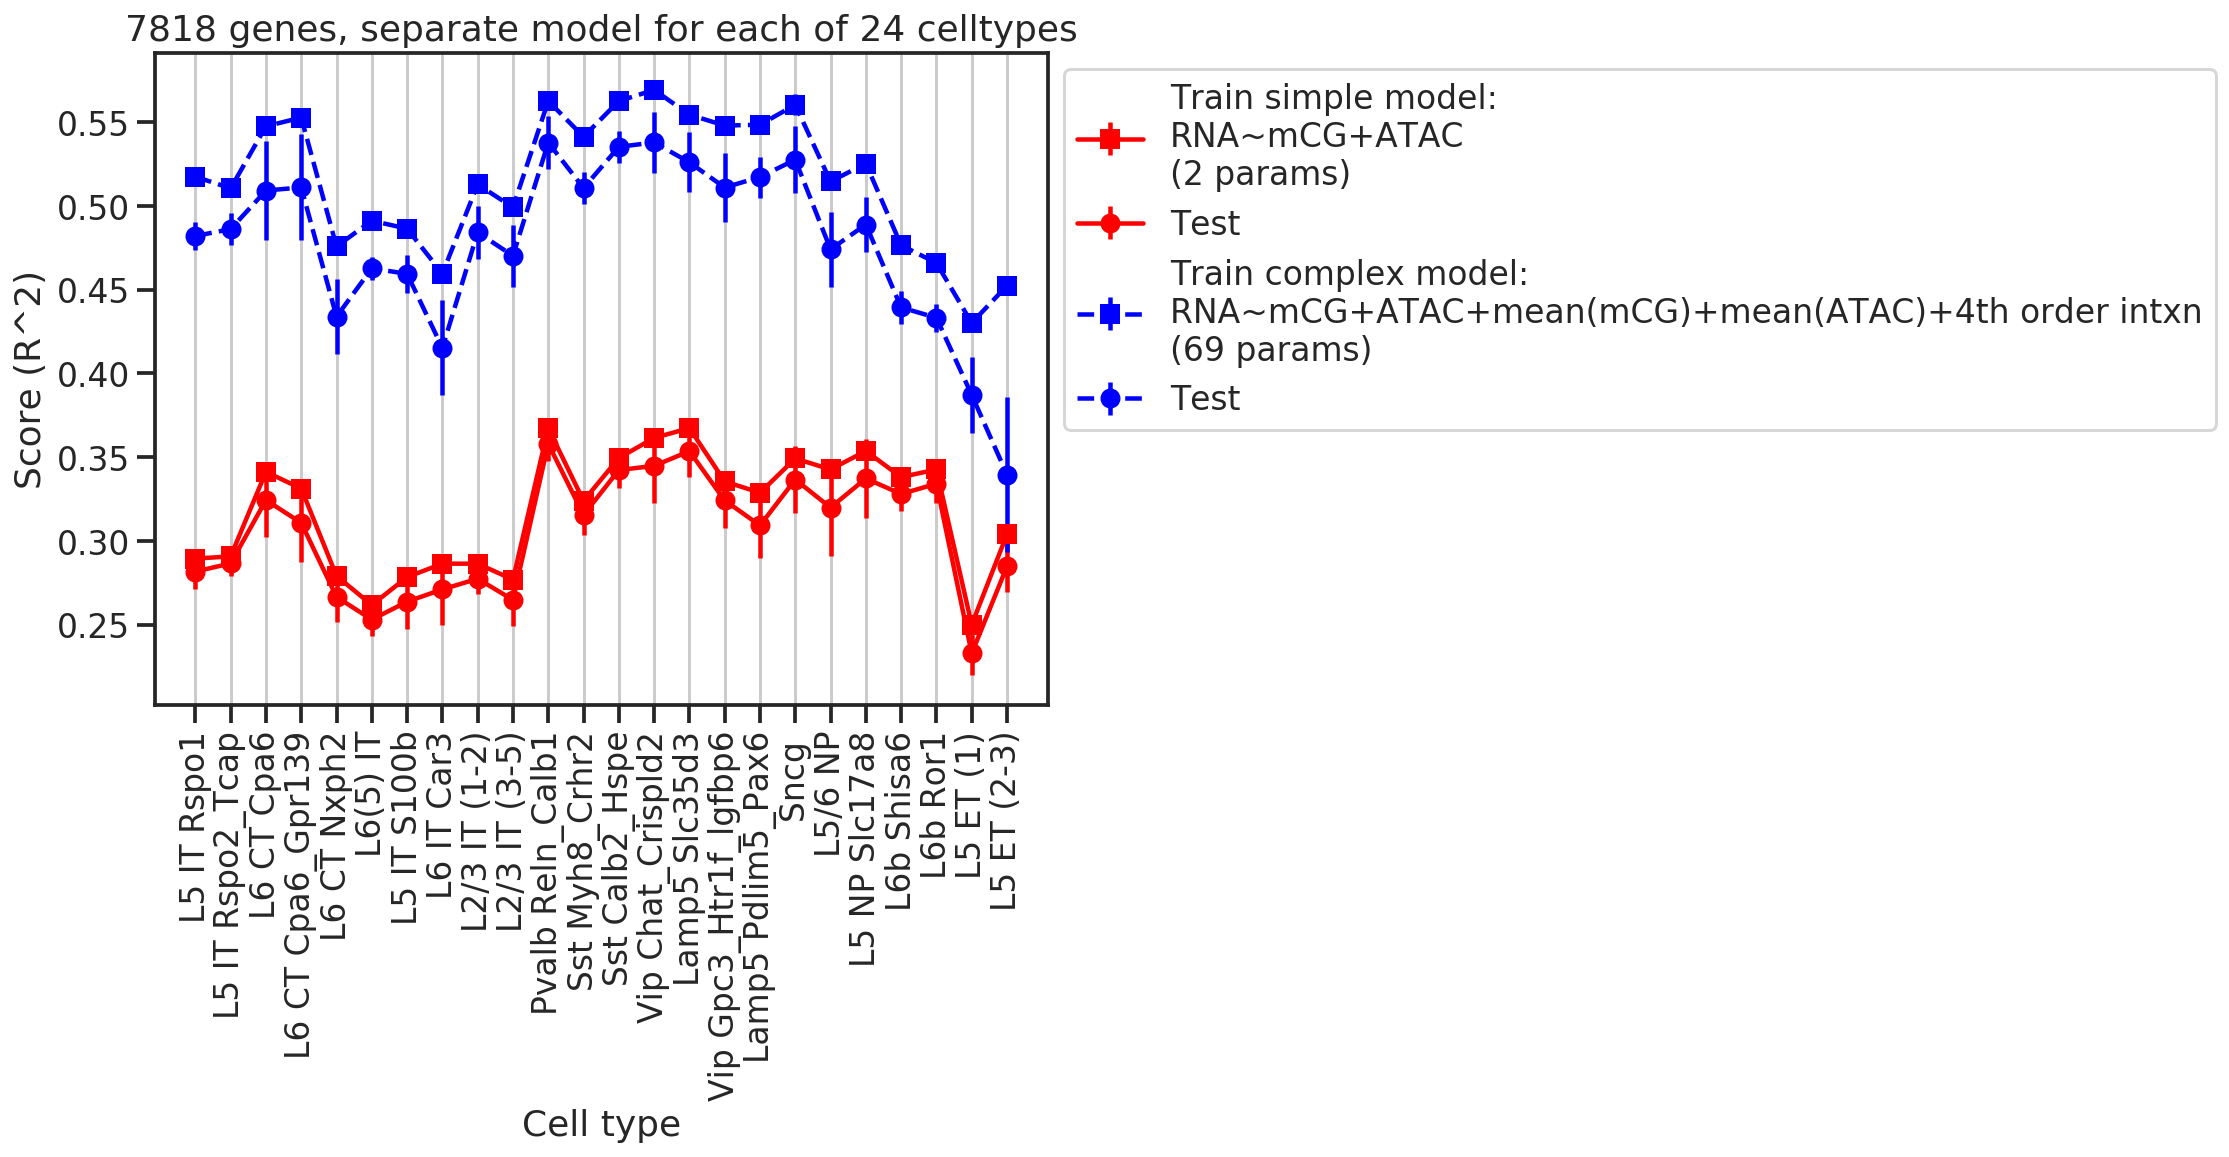

In [177]:
cellnames = df_cellnames.loc[celltypes]['annot']

# Show the OLS results
def myplot(ax, x, label='', fmt=''):
    x[x<0] = 0
    xu = np.sqrt(x)
    ax.errorbar(cellnames, xu.mean(axis=1), xu.std(axis=1)/np.sqrt(cv),
            label=label, fmt=fmt)
    return 
    
fig, ax = plt.subplots(figsize=(8,6))
myplot(ax, res_cv['train_score'],fmt='rs-', label='Train simple model:\nRNA~mCG+ATAC\n(%d params)' % dof_simple)
myplot(ax, res_cv['test_score'],fmt='ro-', label='Test')
myplot(ax, res_cv['train_score_all'],fmt='bs--', label='Train complex model:\nRNA~mCG+ATAC+mean(mCG)+mean(ATAC)+%dth order intxn\n(%d params)' % 
          (intxn_order, dof_complex))
myplot(ax, res_cv['test_score_all'],fmt='bo--', label='Test')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('Cell type')
ax.set_ylabel('Score (R^2)')
ax.xaxis.set_tick_params(rotation=90)
ax.grid(axis='y')
ax.set_title('%d genes, separate model for each of %d celltypes' % y.shape)
snmcseq_utils.savefig(fig, output_fig.format(
        'EnhancerRegression_SigEnhancers_OLS_%dGenes_%dCelltypes_%s' % 
        (genes2enhu.ensid.unique().shape[0], len(celltypes), today)
        ))

In [178]:
# # Multi-task LASSO regression with CV
# from sklearn.linear_model import MultiTaskLassoCV

# t0=time.time()
# mdl = MultiTaskLassoCV(fit_intercept=True, normalize=True, cv=cv, 
#                        selection='random',
#                        random_state=0)

# X = np.concatenate((mc_u,atac_u),axis=1).copy()
# y = np.log10(rna_u+1).copy()

# X = zscore(X[sig_pos,:], axis=0)
# y = zscore(np.log10(y[sig_pos,:]+1), axis=0)

# reg = mdl.fit(X,y)
# print('Done fitting LASSO, t=%3.3f s' % (time.time()-t0))

In [179]:
# plt.errorbar(reg.alphas_, reg.mse_path_.mean(axis=1), reg.mse_path_.std(axis=1))
# plt.vlines(reg.alpha_, plt.ylim()[0], plt.ylim()[1], 'k')
# plt.xscale('log')

In [180]:
# Single task LASSO with CV, interaction terms
from sklearn.linear_model import LassoCV

Xu_all = []
for i,yi in enumerate(y.T):
    Xu = np.concatenate((X[:,[i,i+ncells]],
                         np.mean(X[:,:ncells],axis=1,keepdims=True),
                         np.mean(X[:,ncells:],axis=1,keepdims=True),
                        ),axis=1)
    Xu_all.append(Xu.T)

Xu_all = np.dstack(Xu_all).reshape(4,-1).T
Xu_fit = PolynomialFeatures(degree=intxn_order, include_bias=False).fit(Xu_all)
feature_names = Xu_fit.get_feature_names(input_features=['mC','A','mCm','Am'])
Xu_all = PolynomialFeatures(degree=intxn_order, include_bias=False).fit_transform(Xu_all)

In [181]:
print(Xu_all.shape, y.shape)
yu = y.ravel()
print(Xu_all.shape, yu.shape)

t0=time.time()
mdl = LassoCV(fit_intercept=True, normalize=True, cv=cv, 
              selection='random',
              random_state=0,
              n_jobs=8)
reg = mdl.fit(Xu_all,yu)
print('Done fitting LASSO, t=%3.3f s' % (time.time()-t0))

(187632, 69) (7818, 24)
(187632, 69) (187632,)
Done fitting LASSO, t=9.363 s


Text(0,0.5,'R-squared')

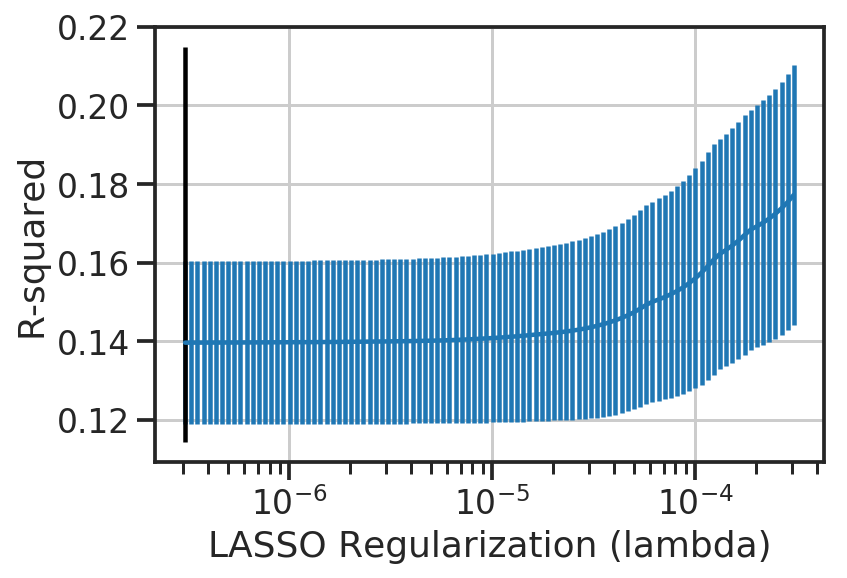

In [182]:
plt.errorbar(reg.alphas_, reg.mse_path_.mean(axis=1), reg.mse_path_.std(axis=1))
plt.vlines(reg.alpha_, plt.ylim()[0], plt.ylim()[1], 'k')
plt.xscale('log')
plt.xlabel('LASSO Regularization (lambda)')
plt.ylabel('R-squared')

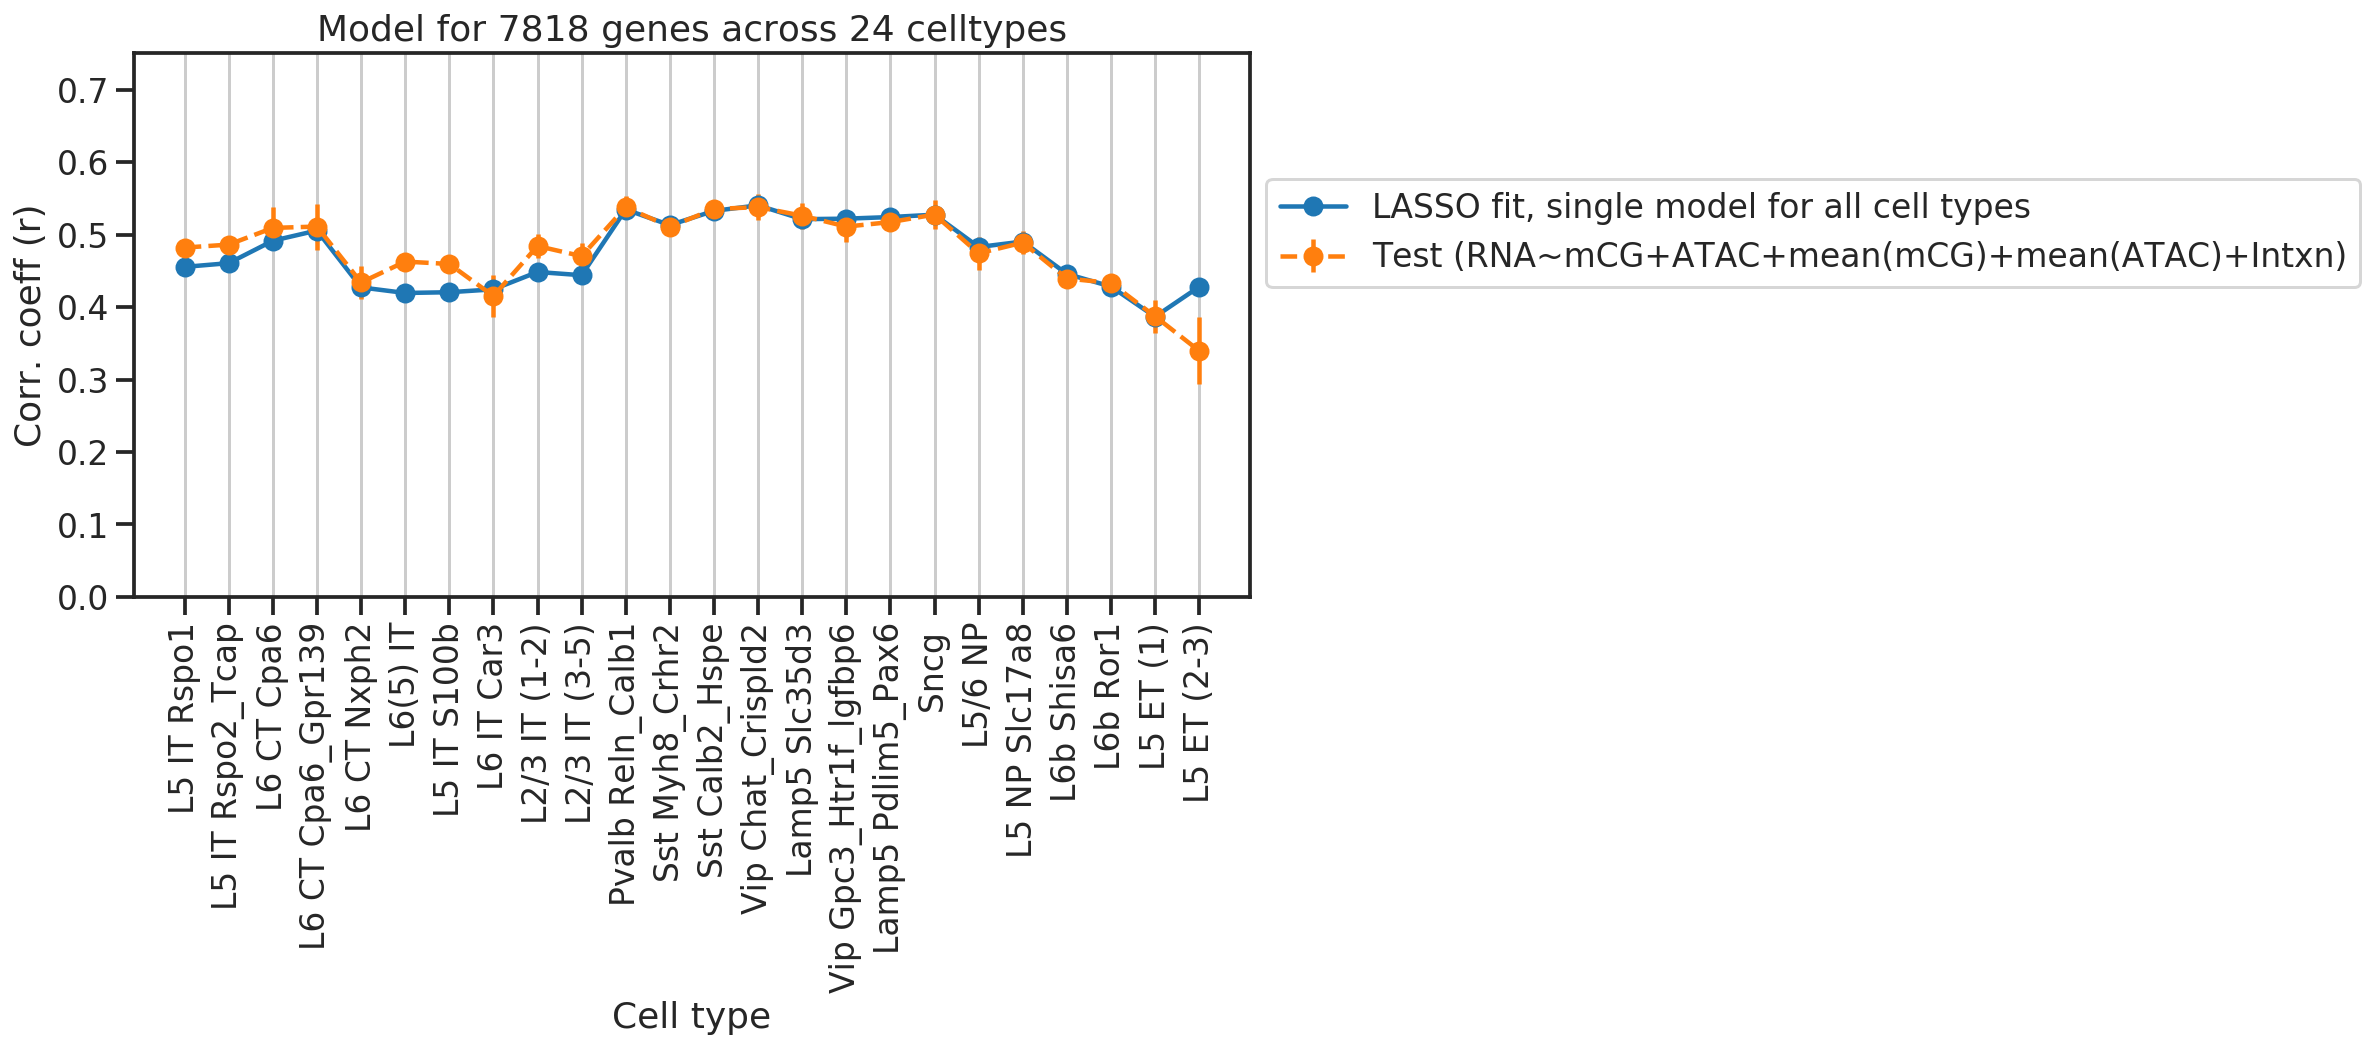

In [187]:
yhat = reg.predict(Xu_all).reshape(y.shape)
cc = [np.corrcoef(y1,y1hat)[0,1] for (y1,y1hat) in zip(y.T,yhat.T)]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(cellnames, cc, 'o-', label='LASSO fit, single model for all cell types')
myplot(ax, res_cv['test_score_all'], label='Test (RNA~mCG+ATAC+mean(mCG)+mean(ATAC)+Intxn)', fmt='o--')
ax.legend(bbox_to_anchor=(1, 0.8))

ax.set_xlabel('Cell type')
ax.set_ylabel('Corr. coeff (r)')
ax.xaxis.set_tick_params(rotation=90)
ax.grid(axis='y')
ax.set_ylim([0,.75])
ax.set_title('Model for %d genes across %d celltypes' % y.shape)

snmcseq_utils.savefig(fig, output_fig.format(
        'EnhancerRegression_SigEnhancers_CompareLASSO_%dGenes_%dCelltypes_%s' % 
        (genes2enhu.ensid.unique().shape[0], len(celltypes), today)
        ))


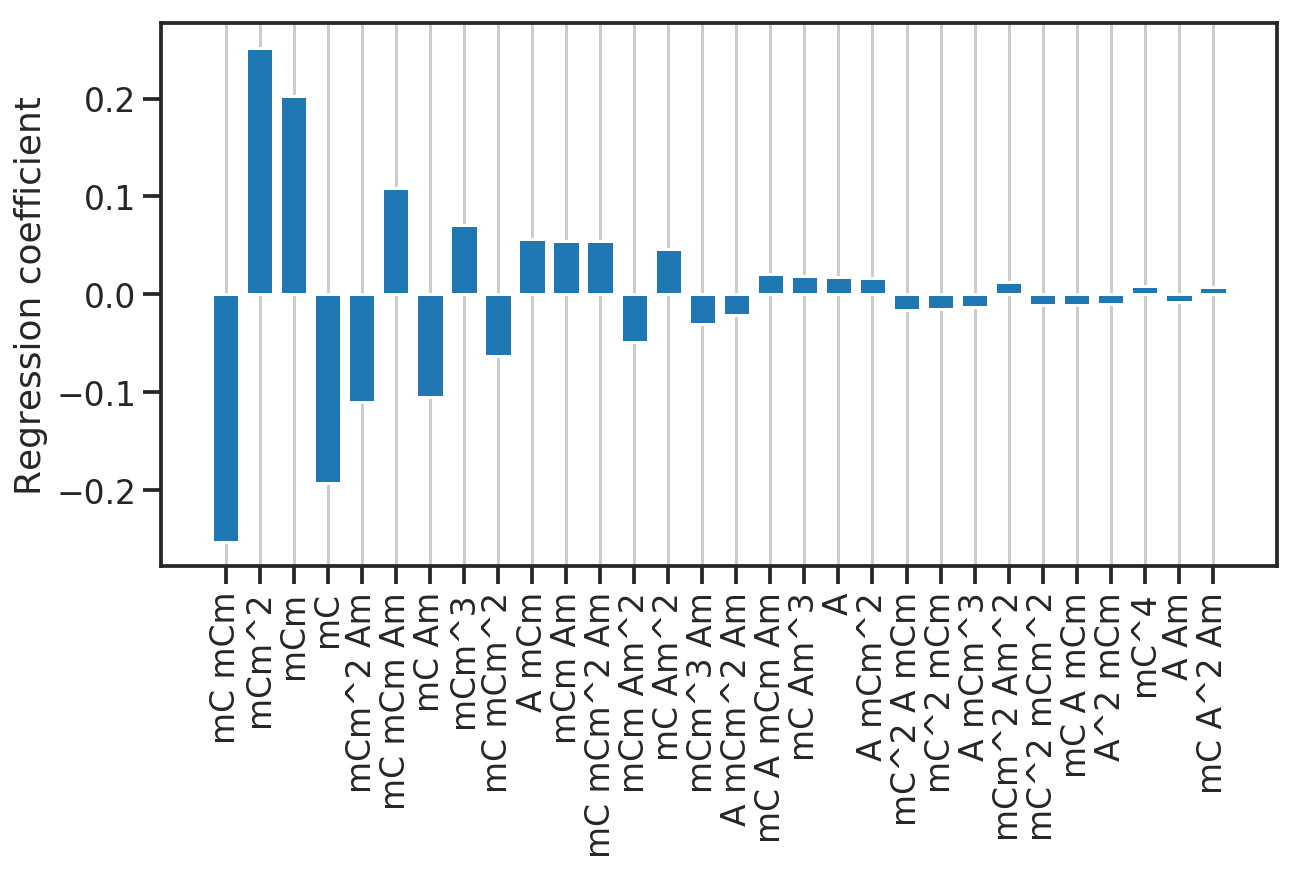

In [185]:
fig, ax = plt.subplots(figsize=(10,5))
show = np.abs(reg.coef_)>0.01
show = np.argsort(np.abs(reg.coef_))[-30:][::-1]
ax.bar(np.array(feature_names)[show], reg.coef_[show])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Regression coefficient')
ax.grid(axis='y')
snmcseq_utils.savefig(fig, output_fig.format(
        'EnhancerRegression_SigEnhancers_LASSO_CorrCoef_%dGenes_%dCelltypes_%s' % 
        (genes2enhu.ensid.unique().shape[0], len(celltypes), today)
        ))

# Apply the nonlinear model to all enhancer

In [188]:
mc_u   = df_mlevelu.loc[genes2enhu['enh_pos'],:].to_numpy()

atac_u = df_atacu.loc[genes2enhu['enh_pos'],:].to_numpy()
genes2enhu_u = genes2enhu.copy()
genes2enhu_u = genes2enhu_u.drop('ensid',axis=1).reset_index()

rna_u = rnau.loc[genes2enhu['ensid'],:].to_numpy()

rna_u.shape, mc_u.shape, atac_u.shape

((468604, 24), (468604, 24), (468604, 24))

In [189]:
X = np.concatenate((mc_u,atac_u),axis=1).copy()
y = np.log10(rna_u+1).copy()

X = zscore(X, axis=0)
y = zscore(y, axis=0)
y = y - np.mean(y,axis=1,keepdims=True)

X.shape, y.shape

((468604, 48), (468604, 24))

In [190]:
Xu_all = []
for i,yi in enumerate(y.T):
    Xu = np.concatenate((X[:,[i,i+ncells]],
                         np.mean(X[:,:ncells],axis=1,keepdims=True),
                         np.mean(X[:,ncells:],axis=1,keepdims=True),
                        ),axis=1)
    Xu_all.append(Xu.T)

Xu_all = np.dstack(Xu_all).reshape(4,-1).T
Xu_fit = PolynomialFeatures(degree=intxn_order, include_bias=False).fit(Xu_all)
feature_names = Xu_fit.get_feature_names(input_features=['mC','A','mCm','Am'])
Xu_all = PolynomialFeatures(degree=intxn_order, include_bias=False).fit_transform(Xu_all)
Xu_all.shape, y.shape

((11246496, 69), (468604, 24))

In [191]:
yhat = reg.predict(Xu_all).reshape(y.shape)

In [192]:
x = df_mlevelu.loc[genes2enhu['enh_pos'],:].to_numpy()
best_cc,best_enh,best_ensid,all_cc = my_cc(-x,y,genes2enhu['ensid'],False,0,corr_type)

Computing correlations for 468604 gene-enhancer pairs; jshuff=0; 


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


t=4.764


In [211]:
(~np.isfinite(best_cc2)).sum()

0

In [193]:
best_cc2,best_enh2,best_ensid2,all_cc2 = my_cc(yhat,y,genes2enhu['ensid'],False,0,corr_type)

Computing correlations for 468604 gene-enhancer pairs; jshuff=0; 
t=4.134


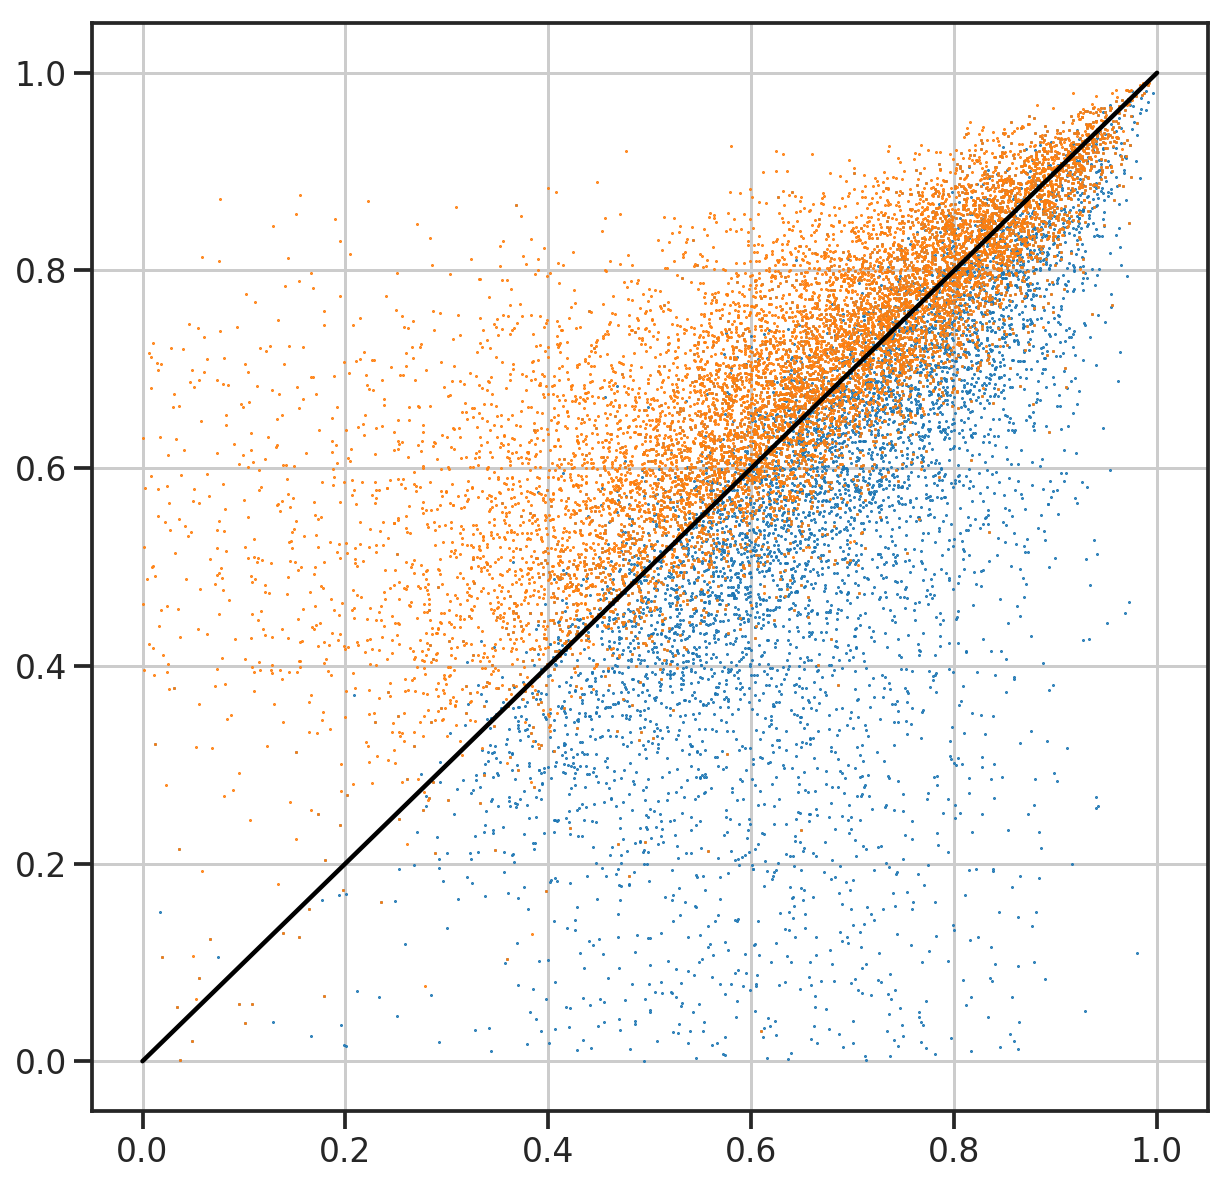

In [257]:
plt.figure(figsize=(10,10))
plt.plot(np.abs(all_cc[best_enh]), np.abs(all_cc2[best_enh]), '.', markersize=1, rasterized=True)
plt.plot(np.abs(all_cc[best_enh2]), np.abs(all_cc2[best_enh2]), '.', markersize=1, rasterized=True)
plt.plot([0,1],[0,1],'k')

In [221]:
np.abs(best_cc2)/(np.abs(best_cc)+1e-6)
best_cc2.shape, best_cc.shape

((9811,), (9811,))

[ 0.94182438  0.53982214  0.99573099 ...,  1.08095031  0.53526436
  0.94957995]


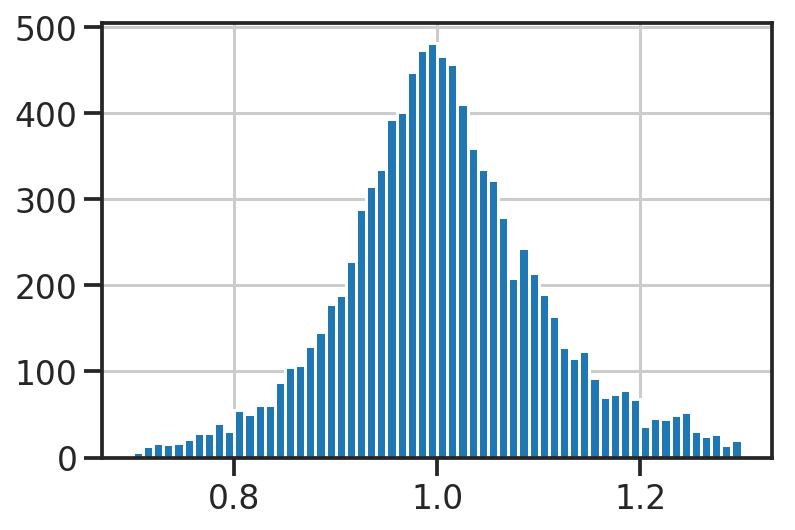

In [224]:
plt.hist(np.abs(best_cc2).values/np.abs(best_cc).values, bins=np.arange(0.7,1.3,0.01));
print(np.abs(best_cc2).values/np.abs(best_cc).values.mean())

In [225]:
# For each gene, find all enhancers with significant cc
df = pd.DataFrame(data=all_cc, columns=['cc'], index=genes2enhu[['ensid','enh_pos']])
df['ensid'] = genes2enhu['ensid'].values
df['enh_pos'] = genes2enhu['enh_pos'].values
df['cc2'] = all_cc2

In [226]:
df['good_pairs'] = df['cc']>0.6
df['good_pairs2'] = df['cc2']>0.6

npairs_df=df.groupby('ensid')[['good_pairs','good_pairs2']].sum()

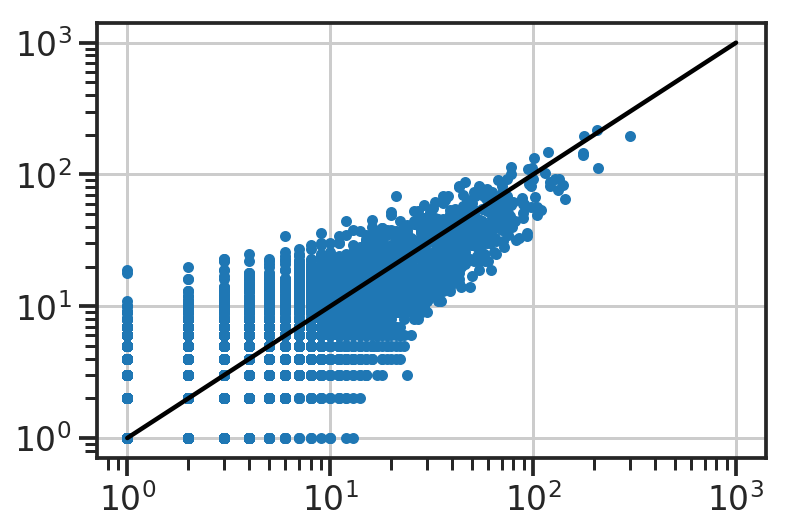

In [229]:
plt.loglog(npairs_df['good_pairs']+1,npairs_df['good_pairs2']+1,'.')
plt.plot([1,1e3],[1,1e3],'k')

In [230]:
np.mean((npairs_df['good_pairs2']+1)/(npairs_df['good_pairs']+1))

1.3398079405596093

# Average over all the enhancers linked to a single gene

In [232]:
def myz(x):
    z = zscore(x, axis=1, nan_policy='omit', ddof=0)
    return z
def make_df(z):
    z_df = pd.DataFrame(data=z, columns=df_mlevelu.columns, index=rnau.index)
    return z_df

multiEnh = {}
multiEnh['rna'] = myz(rnau.values);
multiEnh['rna_hat_1Enh'] = myz(yhat[best_enh2,:])
multiEnh['rna_hat_AllEnh'] = myz(yhat[best_enh2,:])
multiEnh['rna_hat_AllSigEnh'] = np.zeros(yhat[best_enh2,:].shape)+np.nan;
t0=time.time()
for i,c in enumerate(celltypes):
    df = pd.DataFrame(data=yhat[:,i], columns=['yhat'])
    df['ensid'] = genes2enhu.loc[:,'ensid'].values
    multiEnh['rna_hat_AllEnh'][:,i] = df.groupby('ensid')['yhat'].mean()
    df = df.loc[genes2enhu.sig.values,:]
    multiEnh['rna_hat_AllSigEnh'][sig,i] = df.groupby('ensid')['yhat'].mean()
    
multiEnh['rna'] = make_df(multiEnh['rna']);
multiEnh['rna_hat_1Enh'] = make_df(multiEnh['rna_hat_1Enh']);
multiEnh['rna_hat_AllEnh'] = make_df(multiEnh['rna_hat_AllEnh'])
multiEnh['rna_hat_AllSigEnh'] = make_df(multiEnh['rna_hat_AllSigEnh'])
print(time.time()-t0)

1.2156457901000977


Text(0,0.5,'Correlation across genes')

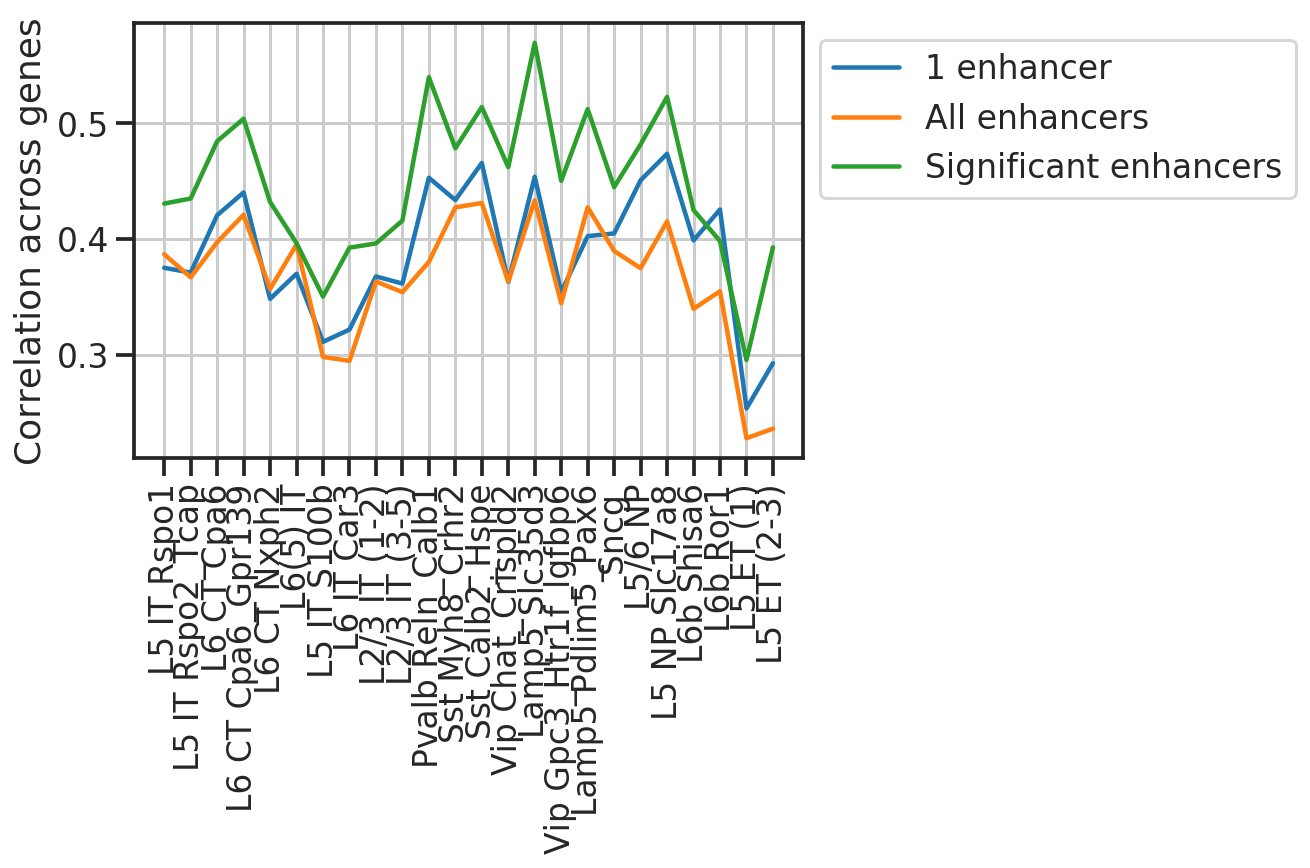

In [235]:
cc_1Enh = np.diag(np.corrcoef(multiEnh['rna'].values, multiEnh['rna_hat_1Enh'].values, rowvar=False)[:ncells,ncells:])
cc_AllEnh = np.diag(np.corrcoef(multiEnh['rna'].values, multiEnh['rna_hat_AllEnh'].values, rowvar=False)[:ncells,ncells:])
cc_AllSigEnh = np.diag(np.corrcoef(multiEnh['rna'].values[sig,:], multiEnh['rna_hat_AllSigEnh'].values[sig,:], rowvar=False)[:ncells,ncells:])

plt.plot(cellnames, cc_1Enh, label='1 enhancer')
plt.plot(cellnames, cc_AllEnh, label='All enhancers')
plt.plot(cellnames, cc_AllSigEnh, label='Significant enhancers')
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=90);
plt.ylabel('Correlation across genes')

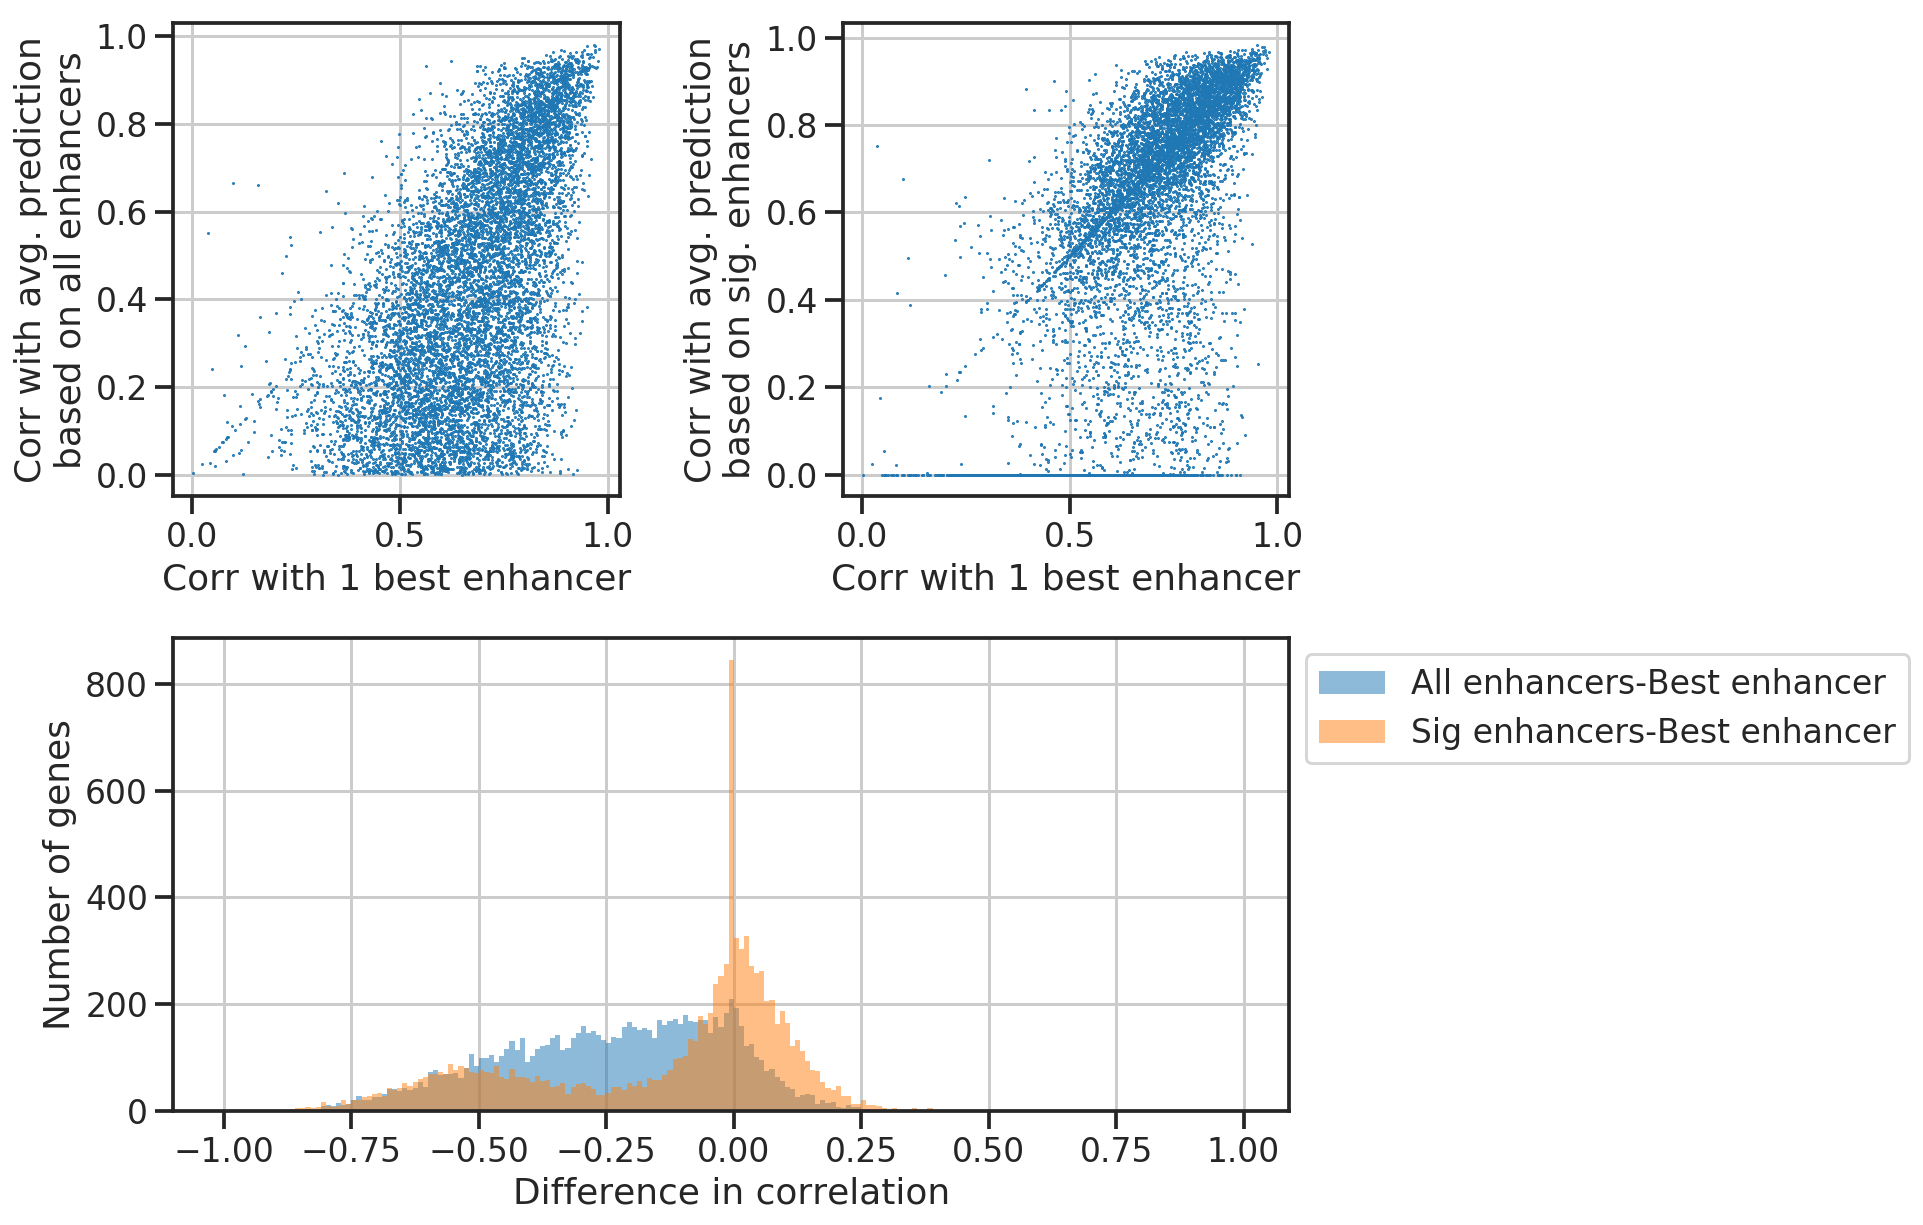

In [271]:
def cc_gene(x,y):
    c = np.nan_to_num([np.corrcoef(x1,y1)[0,1] for (x1,y1) in zip(x,y)])
    return c

cc_1Enh = cc_gene(multiEnh['rna'].values, multiEnh['rna_hat_1Enh'].values)
cc_AllEnh = cc_gene(multiEnh['rna'].values, multiEnh['rna_hat_AllEnh'].values)
cc_AllSigEnh = cc_gene(multiEnh['rna'].values, multiEnh['rna_hat_AllSigEnh'].values)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,2,1)
ax.plot(np.abs(cc_1Enh), np.abs(cc_AllEnh), '.', markersize=1, rasterized=True)
ax.set_xlabel('Corr with 1 best enhancer')
ax.set_ylabel('Corr with avg. prediction\nbased on all enhancers')

ax = fig.add_subplot(2,2,2)
ax.plot(np.abs(cc_1Enh), np.abs(cc_AllSigEnh), '.', markersize=1, rasterized=True)
ax.set_xlabel('Corr with 1 best enhancer')
ax.set_ylabel('Corr with avg. prediction\nbased on sig. enhancers')

ax = fig.add_subplot(2,1,2)
bins = np.arange(-1,1,1/100)
hist_config = {
    'histtype': 'bar', 
    'edgecolor': 'none',
    'alpha': 0.5, 
    'density': False, 
}
ax.hist(np.abs(cc_AllEnh)-np.abs(cc_1Enh), bins=bins, 
         label='All enhancers-Best enhancer', 
         **hist_config,
        )
ax.hist(np.abs(cc_AllSigEnh)-np.abs(cc_1Enh), bins=bins, 
         label='Sig enhancers-Best enhancer', 
         **hist_config,
        )
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Difference in correlation')
ax.set_ylabel('Number of genes')

fig.subplots_adjust(wspace=0.5, hspace=0.3)
snmcseq_utils.savefig(fig, output_fig.format(
        'EnhancerRegression_Correlation_1Enh_vs_AllEnh_%dGenes_%dCelltypes_%s' % 
        (genes2enhu.ensid.unique().shape[0], len(celltypes), today))
        )


# Nonlinear model fitting

In [284]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [285]:
X = np.concatenate((mc_u,atac_u),axis=1).copy()
y = np.log10(rna_u+1).copy()
ngenes,ncells = y.shape

X.shape, y.shape

((468604, 48), (468604, 24))

In [286]:
# Define a class for the NN architecture
Ngenes, Nc = y.shape
Nx = X.shape[1]
N1 = 128
N2 = 32
N3 = 0

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(Nx, N1);
        self.fc2 = nn.Linear(N1, N2);
#         self.fc3 = nn.Linear(N2, N3);
        self.fc4 = nn.Linear(N2, Nc);
        
    def forward(self, x):

        x = F.relu(self.fc1(x))       # Out: N x N1
        x = F.relu(self.fc2(x))       # Out: N x N2
#         x = F.relu(self.fc3(x))       # Out: N x N3
        x = self.fc4(x)               # Out: N x C
        
        return x

In [287]:
# Initialize
def myinit():
    global net, optimizer, criterion, scheduler, loss_test, loss_train, test, train, ensids
    net = Net()
    net.to(device)

#     # Initialize the kmer weights to 0 and turn off learning
#     net.fc1_kmers.requires_grad_(False)
#     net.fc1_kmers.weight.fill_(0)
#     net.fc1_kmers.bias.fill_(0)
    
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25)
    
    loss_test=np.array([])
    loss_train = np.array([])

    # Train/Test split
    test = (np.random.rand(Ngenes,1)<0.2)
    train = [not i for i in test]

    test = np.random.permutation(np.nonzero(test)[0]).squeeze()
    train = np.random.permutation(np.nonzero(train)[0]).squeeze()
    ensids = rnau.index.values
    return

def train_epoch(epoch):
    nsamp = 0
    running_loss = 0.0
    running_time = 0.0
    net.train()
    t0train = time.time()
    for i in range(0, len(train), batch_size):
        tstart = time.time()
        indices = train[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = torch.tensor(X[indices,:],dtype=torch.float)
        batch_y = torch.tensor(y[indices,:],dtype=torch.float)

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_time += time.time()-tstart
        nsamp += len(indices)
        if (time.time()-t0train)>5:
            print('Epoch %d, i=%d/%d, LR=%3.5g, loss=%3.8f, t=%3.3f, %3.5f s/sample' % (epoch, i, len(train), 
                                                                                        optimizer.state_dict()['param_groups'][0]['lr'],
                                                                                        running_loss/nsamp, running_time, running_time/nsamp))
            t0train=time.time()

    return running_loss/nsamp

def test_epoch(epoch):
    
    net.eval()
    running_loss_test = 0.0
    nsamp = 0
    yyhat = {'y':[], 'yhat':[]}
    for i in range(0, len(test), batch_size):
        indices = test[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = torch.tensor(X[indices,:],dtype=torch.float)
        batch_y = torch.tensor(y[indices,:],dtype=torch.float)

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

        # forward + backward + optimize
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        running_loss_test += loss.item()
        nsamp += len(indices)

        yyhat['yhat'].append(outputs.detach().cpu().numpy())
        yyhat['y'].append(batch_y.detach().cpu().numpy())

    return running_loss_test/nsamp


In [288]:
lr = 0.0002
myinit()
train.shape, test.shape

((375173,), (93431,))

In [309]:
import glob
from IPython import display

def test_net(indices):
    net.eval()
    yyhat = {'y':[], 'yhat':[]}
    for i in range(0, len(indices), batch_size):
        i = indices[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = torch.tensor(X[indices,:],dtype=torch.float)
        batch_y = torch.tensor(y[indices,:],dtype=torch.float)

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)

        outputs = net(batch_X)
        
        yyhat['yhat'].append(outputs.detach().cpu().numpy())
        yyhat['y'].append(batch_y.numpy())
    yyhat['yhat'] = np.concatenate(yyhat['yhat'],axis=0)
    yyhat['y'] = np.concatenate(yyhat['y'],axis=0)
    
    cc = np.zeros((Nc,1))
    for i in range(yyhat['y'].shape[1]):
        cc[i,0] = np.corrcoef(yyhat['y'][:,i], yyhat['yhat'][:,i])[0,1]    

    return yyhat, cc

def make_plot1(save=False):
    plt.figure(figsize=(15,4))
    plt.clf()
    plt.subplot(1,3,1)
    plt.semilogx(loss_train[2:],'o-',label='Train')
    plt.plot(loss_test[2:],'o-',label='Test')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(fn_save)

    plt.subplot(1,3,2)
    plt.plot(yyhat_test['y'].T, yyhat_test['yhat'].T,'.');
    plt.plot([0,3],[0,3],'k--')
    plt.xlabel('True RNA expression')
    plt.ylabel('Estimated RNA expression')

    plt.subplot(1,3,3)
    plt.plot(np.arange(Nc), cc)
    plt.ylabel('Correlation coef.')
    plt.xlabel('Cell type')
    plt.legend(['Train','Test'])
    if save:
        fn_plot = output_fig.format(fn_save.replace('.torch','')+'_corrcoef').replace('pdf', 'png')
        plt.savefig(fn_plot)
        print('Saved plot: '+fn_plot)
    plt.tight_layout()
    plt.show();

def make_plot2(save=False):
    plt.figure(figsize=(20,20))
    for i in range(Nc):
        plt.subplot(5,6,i+1)
        plt.plot([0,2],[0,2],'k--')
        plt.plot(yyhat_train['y'][:,i], yyhat_train['yhat'][:,i],'.');
        plt.plot(yyhat_test['y'][:,i], yyhat_test['yhat'][:,i],'.');
    #     cc = np.corrcoef(yyhat['y'][:,i], yyhat['yhat'][:,i])[0,1]
        plt.title('r=%3.3f train/%3.3f test' % (cc[i,0], cc[i,1]))
    if save:
        fn_plot = output_fig.format(fn_save.replace('.torch','')+'_scatter').replace('pdf', 'png')
        plt.savefig(fn_plot)
        print('Saved plot: '+fn_plot)
    plt.tight_layout()
    plt.show();
        
        

<Figure size 432x288 with 0 Axes>

Saved plot: /cndd2/fangming/projects/scf_enhancers/results/figures/eran_model_RegressEnh0032_NoKmers_N_128_32_0.17-06-2020.pt_corrcoef_17-06-2020.png


<Figure size 432x288 with 0 Axes>

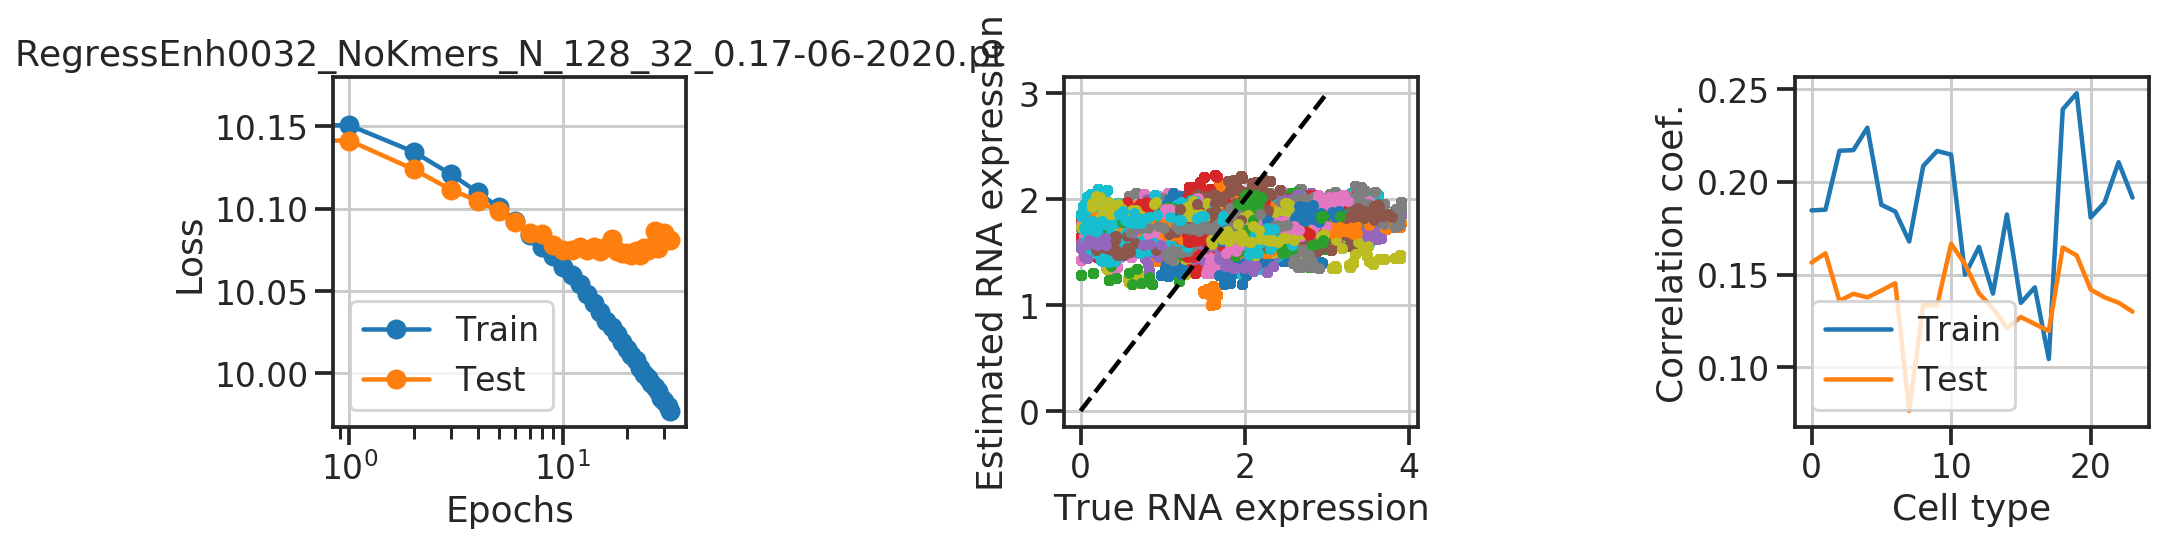

<Figure size 432x288 with 0 Axes>

Saved data: RegressEnh0032_NoKmers_N_128_32_0.17-06-2020.pt


<Figure size 432x288 with 0 Axes>

In [310]:
num_epochs1 = 10

fn_id = len(glob.glob('./RegressEnh*.pt'))+1 # Generate a unique ID for this run
fn_save = 'RegressEnh%0.4d_%s_N_%d_%d_%d.%s.pt' % (fn_id, ('UseKmers' if use_kmers else 'NoKmers'), N1,N2,N3,today)
                            

t0 = time.time()
batch_size = 16
for epoch in range(num_epochs1):  # loop over the dataset multiple times
# while epoch<num_epochs1:
    new_loss_train = train_epoch(epoch);
    loss_train = np.append(loss_train, new_loss_train)
    
    new_loss_test = test_epoch(epoch);
    loss_test = np.append(loss_test,new_loss_test)
    scheduler.step(new_loss_test)

    print('**** Phase1 epoch %d, LR=%3.5g, loss_train=%3.8f, loss_test=%3.8f, time = %3.5f s/epoch' % (
        len(loss_train), 
        optimizer.param_groups[0]['lr'],
        loss_train[-1], 
        loss_test[-1], 
        (time.time()-t0))
         )

    if (time.time()-t0)>60 or (epoch==num_epochs1-1):        
        if (epoch>0):            
            cc = np.zeros((Nc,2))
            yyhat_train, cc[:,[0]] = test_net(random.sample(train.tolist(), 500))
            yyhat_test, cc[:,[1]] = test_net(random.sample(test.tolist(), 500))

            display.clear_output(wait=True)
            display.display(plt.gcf())
            make_plot1(save=True)
#             make_plot2(save=True)  
            display.display(plt.gcf())
        t0=time.time()
        torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_train': loss_train,
                'loss_test': loss_test,
                }, fn_save)
        print('Saved data: %s' % fn_save)


In [307]:
# test.max()
# plt.hist2d(df['log_rna'], mdl.predict(), bins=(50,50), cmap=plt.cm.Reds);
# plt.scatter(df['log_rna'], mdl.predict(),s=1)

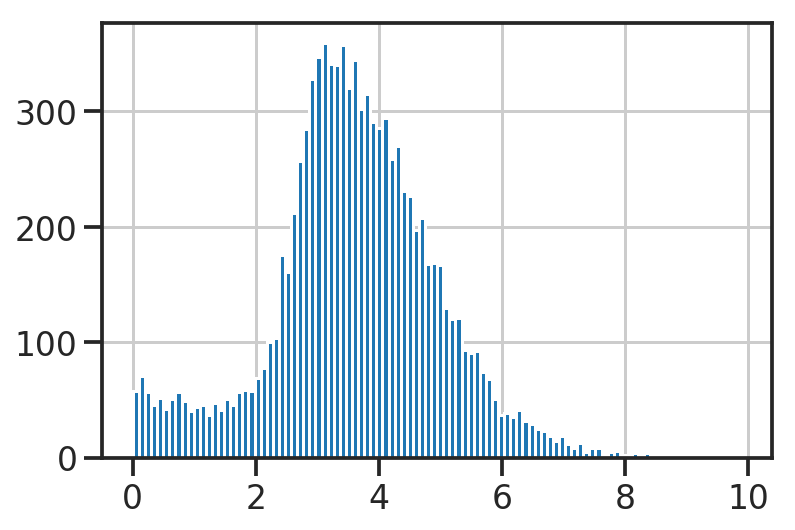

In [308]:
plt.hist(np.log(rnau.loc[genes2enhu['ensid'][best_enh],:].iloc[:,3]+1), bins=100);

### Fangming follow-ups 